<a href="https://colab.research.google.com/github/biedun/JEPSis/blob/main/Training_Unet_resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model based on Transfer Learning - U-Net with ResNet Encoder

To improve the model's precision in predicting the tumor areas, the encoder part of the U-Net is replaced with the ResNet50 structure.
In this way the pretrained weights are kept and can be used for the upsampling in the decoder part in order to improve the dice score.

First part - Set up and training of the U-Net with the ResNet50 from segmentation models library (this notebook)

Second part - Prediction with saved model (see Prediction-Unet-resnet-50.ipynb)

**1. Creation of the transfer learning model**

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import of necessary libraries
import glob
import os
import numpy as np

# modeling
import tensorflow as tf
import keras
!pip install segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.saving import load_model

# visualization
import matplotlib.pyplot as plt
import nibabel as nib # for reading MRT images

**Image EDA**

images


---


- Collect all images in a list (per MRI modality)
- Loading the images per channel - 3 modalities for 3 channels (T1CE, T2, Flair) and the segmentation mask.
- Cropping of slices without information - reduction to 75 slices per patient
- Cropping of image size from 240 to 224
- Combining each channel to one dimension of the 3-dimensional numpy array X with the final shape of (75, 224, 224, 3)
- Saving the array


segmentation masks


---


- Cropping mask image size from 240 to 224
- Convert pixels values into integer
- Renaming class 4 into class 3
- one-hot encoding of the segmentation classes
- Transforming into a 1-dimensional numpy array y with the final shape of (75, 224, 224, 4)
- Saving the array




In [ ]:
# list of images per channel
t2_list = sorted(glob.glob('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))

mask_list = sorted(glob.glob('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

print(f'{len(t2_list)} images per channel are available.')

369 images per channel are available.


In [3]:
data_path = ('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/three_channels')

In [ ]:
#DO NOT RUN IF DATA AVAILABLE!!!

# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

# Define image size
dim = (224, 224)
n_channels = 3

# EDA for every patient in t2_list
for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
    X = np.zeros((VOLUME_SLICES, *dim, n_channels))
    y = np.zeros((VOLUME_SLICES, *dim))
    print(t2_list[img])

    # Loading data, cropping and resizing for every slice of the patient's MRI scan and adding to a numpy array
    # 3D array X for combined image channels, 1D y for segmentation mask
    for j in range(VOLUME_SLICES):

      # T2 for channel 1
      temp_image_t2=nib.load(t2_list[img]).get_fdata()
      X[j,:,:,0] = temp_image_t2[8:232,8:232,j+VOLUME_START_AT]

      # T1CE for channel 2
      temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
      X[j,:,:,1] = temp_image_t1ce[8:232,8:232,j+VOLUME_START_AT]

      # Flair for channel 3
      temp_image_flair=nib.load(flair_list[img]).get_fdata()
      X[j,:,:,2] = temp_image_flair[8:232,8:232,j+VOLUME_START_AT]

      # Segmentation mask
      temp_mask=nib.load(mask_list[img]).get_fdata()
      temp_mask=temp_mask.astype(np.uint8) # convert to integer
      y[j,:,:] = temp_mask[8:232,8:232,j+VOLUME_START_AT]
      y[y==4] = 3  # reassign pixel values 4 to 3

    print(f'''The original shape of the images is {temp_image_t2.shape}.
    After image EDA the shape of the combined array is {X.shape}.''')

    # one-hot encoding of the segmentation classes
    y = to_categorical(y, num_classes=4)
    print (f'After EDA the shape of the segmentation array is {y.shape}.')

    # saving of a X and y numpy arrays per patient
    np.save(data_path + '/image_'+str(img)+'.npy', X)
    np.save(data_path + '/mask_'+str(img)+'.npy', y)

**Prepare the training of the model with 50 random samples**
- select 50 random numbers in the range of available scans (t2_list)
- Combine the array of these 50 samples in a list
- Concatenate the list of these 50 samples to one huge 3D array X
- Split into train, test and validation set

In [ ]:
import random
random.seed(22)
random_numbers = [random.randint(0, len(t2_list)) for _ in range(50)]
#random_numbers

In [ ]:
# Creation of a list for all randomly selected image arrays and for all selected segmentation mask arrays
X = []
y = []

for c in random_numbers:

  # Get path of each RMI modality and the segmentation
  image_path = os.path.join(data_path + '/image_'+str(c)+'.npy')
  mask_path = os.path.join(data_path + '/mask_'+str(c)+'.npy')
  # Load the arrays
  image = np.load(image_path)
  mask = np.load(mask_path)
  # append to image list (X) or segmentation list (y)
  X.append(image)
  y.append(mask)

# Creation of the final arrays with the concatenated samples
X_concatenated= np.concatenate(X, axis=0)
print(X_concatenated.shape)
y_concatenated = np.concatenate(y , axis = 0)
print(y_concatenated.shape)

In [ ]:
# Train-val-test split
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(X_concatenated, y_concatenated, test_size = 0.10, random_state = 0) # 10% of number of patiant files * number of slices

#Further split training data to a small subset for validation (20 %)
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y1))  # 0 is the background/few unlabeled


Class values in the dataset are ...  [0. 1.]


**Defintion of the model**
- number of output classes: 4 - healthy tissue, necrotic core, edema, enhancing tumor
- activation function: softmax (because of multi-classification)
- learning rate: 0.0001
- optimizer: Adam
- loss function: dice loss (overlap-based loss function between ground truth and prediction) and focal loss (to treat sample imbalance, more weight to samples that are hard to classify [Jiang et al. 2021])
- evaluation metric: dice score (2x intersection / (ground truth + prediction))

In [ ]:
n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Loss function
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


#defining the Dice score
import keras.backend as K
def dice_coefficient(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0: # to exclude summing up loss for the prediction of healthy tissue
            total_loss = total_loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / (class_num - 1)
    return total_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coefficient]

In [ ]:
# U-Net model with resnet as backbone of the encoder
BACKBONE1 = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
X_val = preprocess_input(X_val)

# define model & freeze the encoder layers of Unet
resnet_model = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation, encoder_freeze=True)

# compile keras model with defined optimizer, loss and metrics
resnet_model.compile(optim, total_loss, metrics=metrics)

print(resnet_model.summary())


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_54 (ZeroPad  (None, None, None, 3)        0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            



---



**Model Training**

- Training on train data with a batch size of 8 and 50 epochs.
- Validation data is used to check progress and prediction metrics.
- Callbacks to access single epochs after training

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab/JEPSis/random50/model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('/content/drive/MyDrive/Colab/JEPSis/random50/training_x.log', separator=',', append=False)
]

In [ ]:
history=resnet_model.fit(X_train,
          y_train,
          batch_size=8,
          epochs=50,
          verbose=1,
          callbacks=callbacks,
          validation_data=(X_val, y_val))


resnet_model.save('/content/drive/MyDrive/Colab/JEPSis/random50/res50_backbone_50epochs_random_50_4.hdf5')



---


**Evaluate trained model for prediction**

For this purpose two main tests are done:
1. Load the  training logs to compare the epochs regarding loss, dice coefficent and Mean IOU.
2. Compare the prediction of the segmented tumor to the original segmentation mask.

**Taining Logs**

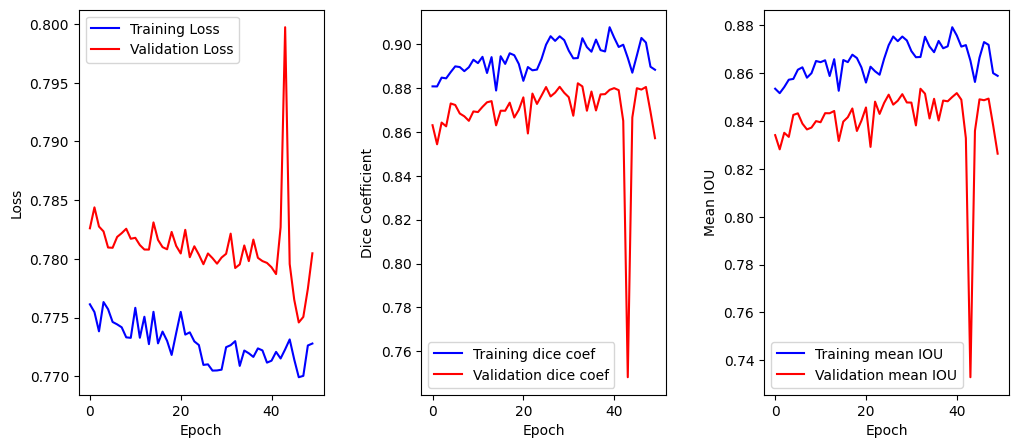

In [43]:
import pandas as pd

# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('/content/drive/MyDrive/JEPSis/random50/training_4.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[0].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history['epoch'], history['dice_coefficient'], 'b', label='Training dice coef')
axs[1].plot(history['epoch'], history['val_dice_coefficient'], 'r', label='Validation dice coef')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice Coefficient')
axs[1].legend()

axs[2].plot(history['epoch'], history['iou_score'], 'b', label='Training mean IOU')
axs[2].plot(history['epoch'], history['val_iou_score'], 'r', label='Validation mean IOU')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Mean IOU')
axs[2].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()



---


**Comparison of Original Segmentation vs. Prediction**
To achieve this several functions are incorporated. For a more detailed explanation of the prediciton, have a look in our Notebook Prediction-Unet-resnet50.ipynb  

In short:
- **load_resnet()** - aims for loading the trained and saved model
- **get_random_filenames()** - chooses a random sample from the numpy arrays which were previously created and saved

> Therefore the first steps of this notebook are necessary, the Prediction-Unet-resnet50.ipynb works with NifTi files instead of numpy arrays

- **load_npy_samples()** - loads the numpy-arrays of the chosen samples (image and mask)
- **predict_segmentation()** - before predicting upon the model, this function preprocesses the image-array according to the resnet50-requirements
- **plot_segmentation()** - selects and plots the slice with the largest tumor area together with the true/original segmentation



In [5]:
#Set compile=False as we are not loading it for training, only for prediction.
from tensorflow.keras.saving import load_model

def load_resnet():
  resnet_model = load_model('/content/drive/MyDrive/JEPSis/random50/res50_backbone_50epochs_random_50_4.hdf5', compile=False)
  return resnet_model

resnet_model = load_resnet()

In [9]:
# choose random sample number from the previously 369 transformed sample numpy arrays
import random

def get_random_filenames():
    # Generate a random number between 0 and 368
    random_number = random.randint(0, 368)

    # Rebuild the filenames
    image_filename = f"image_{random_number}.npy"
    mask_filename = f"mask_{random_number}.npy"

    return image_filename, mask_filename


Randomly selected image filename: image_9.npy
Corresponding mask filename: mask_9.npy


In [13]:
data_path = '/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/three_channels/'

In [15]:
# load random image and mask
def load_npy_samples(data_path):
  #select random sample
  image_filename, mask_filename = get_random_filenames()
  #recreate path
  image_path = os.path.join(data_path + image_filename)
  mask_path = os.path.join(data_path + mask_filename)
  #load image and mask array
  test_image = np.load(image_path)
  mask = np.load(mask_path)
  print(f"Randomly selected image filename: {image_filename}")
  print(f"Corresponding mask filename: {mask_filename}")
  return test_image, mask


In [37]:
# preprocess and predict
def predict_segmentation(data_path):
  #load preprocessing of pretrained resnet50
  BACKBONE1 = 'resnet50'
  preprocess_input1 = sm.get_preprocessing(BACKBONE1)

  # load arrays via previous function
  test_image, mask = load_npy_samples(data_path)

  # preprocess input and make prediction of segmentation
  final_test_image = preprocess_input1(test_image)
  mask_pred = resnet_model.predict(final_test_image)

  # choose class of segmentation pixels
  mask_pred_argmax = np.argmax(mask_pred, axis=3)

  return final_test_image, mask, mask_pred, mask_pred_argmax

In [67]:
from matplotlib.colors import LinearSegmentedColormap

def plot_prediction(data_path):

  # loading a randomly picked image and make prediction
  final_test_image, mask, mask_pred, mask_pred_argmax = predict_segmentation(data_path)

  # selecting the slice with the largest tumor area by creating a list of all slices
  nonzero_count=[]
  for i in range(len(mask_pred_argmax)):
    nonzero_count.append(np.count_nonzero(mask_pred_argmax[i,:,:]))

  # select slice with largest tumor area by index
  max_index = np.argmax(nonzero_count)

  # loading array of selected slice
  test_img = final_test_image[max_index]

  y_pred_view = mask_pred_argmax[max_index,:,:]
  test_img_view_t2=test_img[:,:,0]
  test_img_view_t1ce=test_img[:,:,1]
  test_img_view_t2flair=test_img[:,:,2]
  true_seg = mask[max_index, :, :]

  ## Create figure of the colored segmentation
  colors = [(0, 0, 0),  # black
            (0, 0, 1),  # blue for necrotic core
            (0, 1, 0),  # green for edema
            (1, 1, 0)]  # yellow for enhancing tumor

  custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=10)

  print('This is the result of your uploaded files: predicted segmentation of the tumor')
  print('The image shows the largest tumor area, which is slice number', max_index)
  fig1, axs = plt.subplots(1, 2, figsize=(12, 4))
  fig1.patch.set_facecolor('black')
  for ax, data, title in zip(axs, [true_seg, y_pred_view], ['Original segmentation', 'Predicted segmentation']):
      ax.imshow(data, cmap=custom_cmap)
      ax.set_title(title, color='white' , fontsize = 15)
      ax.axis('off')  # Remove the axes
      ax.set_facecolor('black')  # Set subplot background to black
  plt.subplots_adjust(wspace=2, hspace=0)  # Adjust the space between subplots
  plt.show()

  print('necrotic core in blue, enhancing tumor in yellow and the edema in green')


Randomly selected image filename: image_132.npy
Corresponding mask filename: mask_132.npy
3/3 [==============================] - 26s 7s/step
This is the result of your uploaded files: predicted segmentation of the tumor
The image shows the largest tumor area, which is slice number 35


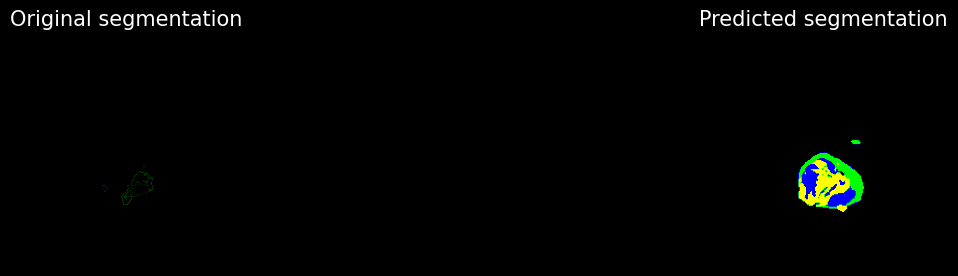

necrotic core in blue, enhancing tumor in yellow and the edema in green


In [68]:
plot_prediction(data_path)

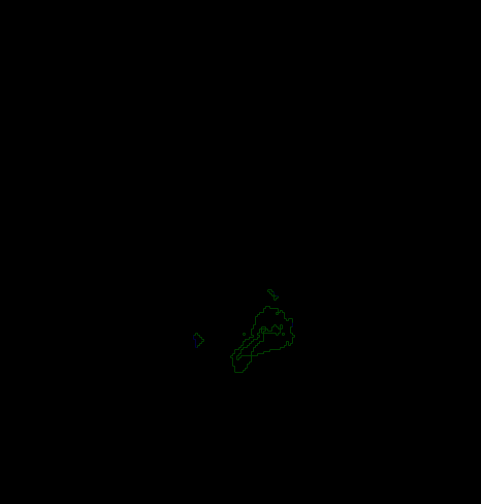

In [71]:
colors = [(0, 0, 0),  # black
         (0, 0, 1),  # blue for necrotic core
         (0, 1, 0),  # green for edema
         (1, 1, 0)]  # yellow for enhancing tumor

custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=10)
mask_path = os.path.join(data_path + 'mask_132.npy')
  #load image and mask array
mask = np.load(mask_path)
true_seg = mask[35, :, :]
fig2 = plt.figure(figsize=(6,6))
plt.imshow(true_seg)#, cmap=custom_cmap)
plt.title('Custom Colormap Image')
plt.axis('off')
fig2.patch.set_facecolor('black')
plt.show()